<a href="https://colab.research.google.com/github/SupidchayaTangkidwanich/Train_test_new/blob/main/Freeze_Train_id10_id12_id2_id6_Test_id8_100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Freeze

In [1]:
from google.colab import drive # เชื่อมเข้ากับ Drive
drive.mount('/content/drive')  # คลิกที่ลิงก์ -> เลือก E-mail -> ลงชื่อเข้าใช้ -> ก็อปโค้ด -> นำกลับมาวางในช่องว่าง -> กด enter

Mounted at /content/drive


In [2]:
ls

drive/  sample_data/


## Load model

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [4]:
batch_size = 20
width = 150
height = 150
epochs = 100
NUM_TRAIN = 100
NUM_TEST = 100
dropout_rate = 0.2
input_shape = (height, width, 3)

In [5]:
#ดึงข้อมูลใน Github มาใช้
import os
%cd /content
if not os.path.isdir("efficientnet_keras_transfer_learning"):
 !git clone https://github.com/Wanita-8943/efficientnet_keras_transfer_learning
%cd efficientnet_keras_transfer_learning/

/content
Cloning into 'efficientnet_keras_transfer_learning'...
remote: Enumerating objects: 837, done.
remote: Counting objects: 100% (359/359), done.
remote: Compressing objects: 100% (124/124), done.
remote: Total 837 (delta 255), reused 328 (delta 235), pack-reused 478
Receiving objects: 100% (837/837), 13.82 MiB | 27.42 MiB/s, done.
Resolving deltas: 100% (495/495), done.
/content/efficientnet_keras_transfer_learning


In [6]:
# Options: EfficientNetB0, EfficientNetB1, EfficientNetB2, EfficientNetB3
# Higher the number, the more complex the model is.
from efficientnet import EfficientNetB0 as Net
from efficientnet import center_crop_and_resize, preprocess_input

In [7]:
# loading pretrained conv base model
# โหลดโมเดล มาโดยตัด output ของโมเดลออก เเต่ยังใช้ input อันเดิม
# เเละโหลด weight ของโมเดล มาด้วยที่ชื่อว่า imagenet
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


16717576/16717576 [==============================] - 0s 0us/step


In [8]:
conv_base.summary() #ดู Summary

Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 75, 75, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                    

In [9]:
import pandas as pd
import shutil

In [10]:
df = pd.read_csv (r'/content/drive/MyDrive/data/id8_test.csv')
df

,Unnamed: 0,Path_Name,id,Part
0,0,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
1,1,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
2,2,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
3,3,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
4,4,/content/drive/My Drive/id/id10/Base/p13/dis1....,id10,p13
...,...,...,...,...
243523,243523,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07
243524,243524,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07
243525,243525,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07
243526,243526,/content/drive/My Drive/id/id8/Severe/p07/dis1...,id8,p07


In [11]:
train = df[df['Unnamed: 0'].between(0,192443)]
test = df[df['Unnamed: 0'].between(192444,243527)]

In [12]:
DATA_PATH = "/content/drive/My Drive/id"
os.chdir(DATA_PATH)
train_dir = os.path.join(DATA_PATH, 'train')
print(train_dir)
test_dir = os.path.join(DATA_PATH, 'test')
print(test_dir)

/content/drive/My Drive/id/train
/content/drive/My Drive/id/test


## Train

In [13]:
# Train ด้วย ImageDataGenerator ของ Keras ซึ่งจะเพิ่มข้อมูลเสริมระหว่างการฝึกเพื่อลดโอกาสเกิด overfitting
#overfitting เกิดจากข้อมูลที่ซับซ้อนกันเกินไป
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      rescale=1./255, #โมเดลส่วนใหญ่ต้องใช้ RGB ในช่วง 0–1
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
        dataframe = train,
        directory = train_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

test_generator = test_datagen.flow_from_dataframe(
        dataframe = test,
        directory = test_dir,
        x_col = 'Path_Name',
        y_col = 'Part',
        target_size=(height, width),
        batch_size=batch_size)

Found 192444 validated image filenames belonging to 15 classes.


In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(15, activation='softmax', name="fc_out"))

In [ ]:
model.summary()

In [ ]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

In [ ]:
model.summary()

## Training

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])
history = model.fit_generator(
      train_generator,
      steps_per_epoch= NUM_TRAIN //batch_size,
      epochs=epochs,
      validation_data=test_generator,
      validation_steps= NUM_TEST //batch_size,
      verbose=1,
      use_multiprocessing=True,
      workers=4)

<ipython-input-19-6ef5d1e0375e>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100
5/5 [==============================] - 47s 8s/step - loss: 5.5447 - acc: 0.1200 - val_loss: 4.0948 - val_acc: 0.2000
Epoch 2/100
5/5 [==============================] - 29s 5s/step - loss: 4.2478 - acc: 0.1500 - val_loss: 3.2693 - val_acc: 0.2800
Epoch 3/100
5/5 [==============================] - 53s 11s/step - loss: 3.9299 - acc: 0.1400 - val_loss: 4.3077 - val_acc: 0.1300
Epoch 4/100
5/5 [==============================] - 32s 6s/step - loss: 3.4730 - acc: 0.2000 - val_loss: 2.8667 - val_acc: 0.3500
Epoch 5/100
5/5 [==============================] - 28s 5s/step - loss: 3.2670 - acc: 0.2500 - val_loss: 2.7496 - val_acc: 0.2700
Epoch 6/100
5/5 [==============================] - 29s 5s/step - loss: 3.1227 - acc: 0.2700 - val_loss: 2.2324 - val_acc: 0.3300
Epoch 7/100
5/5 [==============================] - 32s 6s/step - loss: 2.6247 - acc: 0.2500 - val_loss: 2.3587 - val_acc: 0.3300
Epoch 8/100
5/5 [==============================] - 33s 7s/step - loss: 2.9318 - acc: 0.2900 - va

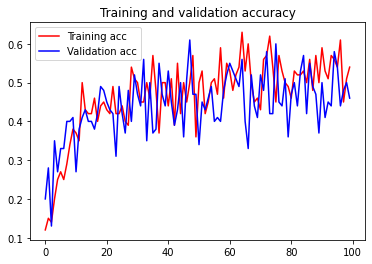

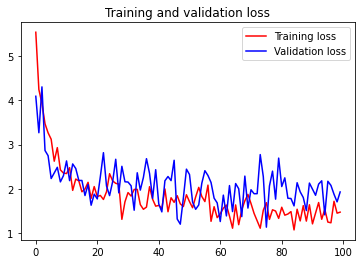

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'r', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'r', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## save model

In [ ]:
os.makedirs('/content/drive/MyDrive/Model', exist_ok=True)
model.save('/content/drive/My Drive/Model/Freeze_Train_id10_id12_id2_id6_Test_id8_100.h5')

In [ ]:
from google.colab import files